Using the shot chart avaialable for each nba player via the nba api to create a machine learning routine that should be capable of predicting whether or not a basket will go in.

Variables include position, coverage, and time. 

Making it one big function that way as soon as you end the player, its done

In [15]:
from nba_py import player
import numpy as np
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(4)  #replication purposes.
import matplotlib.pyplot as plt
from sklearn import preprocessing, cross_validation, neighbors

from nba_py import shotchart
%matplotlib inline

height has been deprecated.



/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
def get_PID(first_name,last_name):
    """Obtains the player ID number of the desired player.
    
    Parameters
    -----------
    
    first_name: str
        First name of player
    last_name: str
        Last name of player
    
    Returns
    -------
    
    ID : float
        The player's ID number. 
    """
    
    playa = player.get_player(first_name=first_name,last_name=last_name)
    
    return playa.values[0]
def get_shotchart(PID):
    """Returns a dataframe of the shotchart.
    """
    chart = shotchart.ShotChart(PID)
    chartdf = chart.shot_chart()
    
  #  importantstuff = chartdf[['LOC_X','LOC_Y','SHOT_DISTANCE','ACTION_TYPE','EVENT_TYPE']].copy()   #['LOC_X','LOC_Y','EVENT_TYPE']
    importantstuff = chartdf[['LOC_X','LOC_Y','ACTION_TYPE','EVENT_TYPE']].copy()
    importantstuff = pd.get_dummies(importantstuff)
    return importantstuff

In [71]:
def analyze_player(first,last,plot=True,cluster=True):
    """Wrapper function which does everything in one, 
    no need to specify each table specific to that player right away!
    
    Parameters
    -----------
    first and last name of the player, comma separated, string format. 
    
    and a plotting option to see the shot chart, and anything else if I think of it. 
    and a cluster option to try and use ML to predict whether or not a shot goes in!
    
    Returns
    -------
    
    Shot chart, clustering success, anything else
    """
    
    
    PID = get_PID(first,last)
    
    playertable =  get_shotchart(PID)
    #print(playertable)
    if plot: 
        makes = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 0]
        misses = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 1]
        xmade = makes['LOC_X'].values/10
        ymade = makes['LOC_Y'].values/10
        xmissed = misses['LOC_X'].values/10
        ymissed = misses['LOC_Y'].values/10
        x = np.linspace(-60,60,100)

        for i in range(len(x)):
            r = 22
            y = np.sqrt(r**2 - x**2)
        plt.plot(xmade,ymade,'bo',label = 'made')
        plt.plot(xmissed,ymissed,'rx',label = 'missed')
        plt.plot(x,y,label = 'rough 3pt line')
        plt.xlim((-25, 25))  
        plt.ylim((0, 35))  

        plt.title("Shot Chart of " + first + " " + last)
        plt.xlabel('dist. from hoop (ft)')
        plt.ylabel('dist. from hoop (ft)')

        plt.legend()
    if cluster:
        y = playertable[['EVENT_TYPE_Made Shot','EVENT_TYPE_Missed Shot']].values
        del playertable['EVENT_TYPE_Made Shot'],playertable['EVENT_TYPE_Missed Shot']
        X = playertable.values
        X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
        clf = neighbors.KNeighborsClassifier(n_neighbors=500,leaf_size=15)
        clf.fit(X_train,y_train)
        accuracy = clf.score(X_test,y_test)
        print("Accuracy of clustering:",accuracy,"%.")

Accuracy of clustering: 0.6130952380952381 %.


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in sqrt


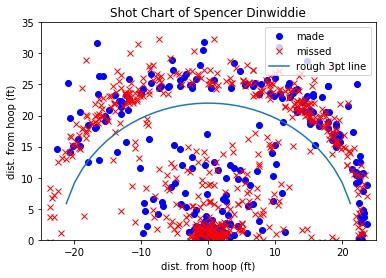

In [72]:
analyze_player('Spencer','Dinwiddie')

If I had to guess these lines are on the line, so approximately speaking 220 of these units corresponds to 22 feet. Ie divide by 10 to obtain feet. Doing this now!

In [34]:
x = np.linspace(-32,32,100)

for i in range(len(x)):
    r = 22
    y = np.sqrt(r**2 - x**2)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


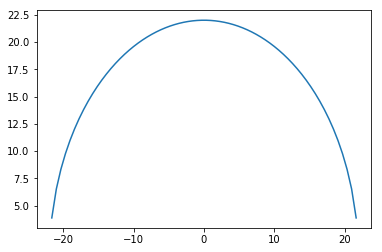

In [35]:
plt.plot(x,y)